# EM31 Geophysical Analysis – Eighty Acres Sanitary Landfill

This notebook presents a geostatistical analysis of EM31 conductivity and in-phase measurements collected over the Eighty Acres Sanitary Landfill site.

The objective is to:
- Characterize spatial structure in the EM data
- Interpolate conductivity and in-phase responses using ordinary kriging
- Quantify uncertainty conservatively using spatial cross-validation
- Produce probability-of-exceedance maps to guide follow-up field decisions

All modeling is performed in the local site coordinate system used during data collection. 


In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from pykrige.ok import OrdinaryKriging
from skgstat import Variogram

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial.distance import pdist, cdist
from scipy.optimize import curve_fit
print('GeoAI OK')

GeoAI OK


## Data Ingestion and Quality Control

The EM31 dataset is provided as a delimited text file containing survey line identifiers, station numbers, local site coordinates (easting and northing), and measured in-phase and conductivity responses.

Initial data ingestion focuses on:
- Verifying column definitions, units, and data types
- Identifying missing or malformed records
- Confirming survey geometry and nominal point spacing
- Screening for gross outliers or logging artifacts

Quality control at this stage is intentionally conservative. No filtering or smoothing is applied beyond the identification of clearly invalid values. Subsequent modeling steps explicitly account for measurement noise, sub-grid variability, and placement uncertainty through variogram structure and cross-validation, rather than aggressive preprocessing.


In [2]:
# Path to data file
data_path = "../data/EAEMDataFinal.DAT"

# Load the data
# File is comma-delimited text despite .DAT extension
df = pd.read_csv(data_path)

# Standardize column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(".", "", regex=False)
)

# Display basic structure
print("Data shape:", df.shape)
display(df.head())

# Summary info
df.info()

# Basic descriptive statistics for EM measurements
em_cols = ["inphase", "conduc"]
df[em_cols].describe()


Data shape: (824, 6)


,profile,station,easting,northing,inphase,conduc
0,0,0,0,0,1089,27.1
1,0,10,10,0,1084,27.8
2,0,20,20,0,1087,27.7
3,0,30,30,0,1082,25.4
4,0,40,40,0,1081,24


<class 'pandas.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   profile   824 non-null    int64
 1   station   824 non-null    int64
 2   easting   824 non-null    int64
 3   northing  824 non-null    int64
 4   inphase   824 non-null    str  
 5   conduc    824 non-null    str  
dtypes: int64(4), str(2)
memory usage: 38.8 KB


,inphase,conduc
count,824,824
unique,113,307
top,1131,*
freq,24,18


In [3]:
# Handle missing values encoded as '*'
em_cols = ["inphase", "conduc"]

df[em_cols] = (
    df[em_cols]
    .replace("*", np.nan)
    .astype(float)
)

# Confirm conversion
df[em_cols].info()

<class 'pandas.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   inphase  806 non-null    float64
 1   conduc   806 non-null    float64
dtypes: float64(2)
memory usage: 13.0 KB


In [4]:
# Count missing values
df[em_cols].isna().sum()

inphase    18
conduc     18
dtype: int64

A small number of EM31 readings are flagged as missing in the original field file using a `"*"` character. These values are treated as missing (`NaN`) and excluded from subsequent modeling steps. Given their low frequency relative to the total number of measurements, no imputation is performed.

Unique easting step(s): [10]
Unique northing step(s): [10]


count    824.0
mean      10.0
std        0.0
min       10.0
5%        10.0
25%       10.0
50%       10.0
75%       10.0
95%       10.0
max       10.0
dtype: float64

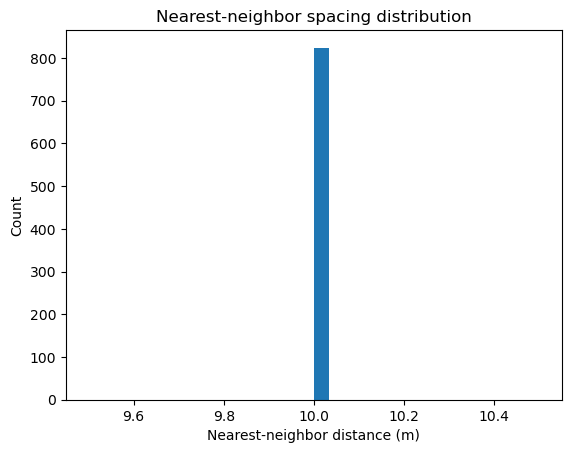

In [5]:
# Spacing / survey geometry checks
# Goal: confirm nominal ~10 m spacing and quantify heterogeneity

coords = df[["easting", "northing"]].to_numpy()

# Unique coordinate steps (good for rectilinear grids)
dx_unique = np.unique(np.diff(np.unique(df["easting"])))
dy_unique = np.unique(np.diff(np.unique(df["northing"])))

print("Unique easting step(s):", dx_unique)
print("Unique northing step(s):", dy_unique)

# Nearest-neighbor distance statistics (robust to missing points)
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2, algorithm="auto").fit(coords)
distances, indices = nn.kneighbors(coords)

# distances[:, 0] is always 0 (point to itself); nearest neighbor is distances[:, 1]
nn_dist = distances[:, 1]

summary = pd.Series(nn_dist).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
display(summary)

# Quick histogram of nearest-neighbor distances
plt.figure()
plt.hist(nn_dist, bins=30)
plt.xlabel("Nearest-neighbor distance (m)")
plt.ylabel("Count")
plt.title("Nearest-neighbor spacing distribution")
plt.show()

Survey geometry confirms a uniform 10 m grid in both easting and northing directions. Given the regular spacing and absence of interior gaps, no further geometry correction is required.

## 3. Exploratory Data Analysis (EDA)

The purpose of this exploratory analysis is to characterize the statistical and spatial properties of the EM31 conductivity and in-phase measurements prior to geostatistical modeling. Specifically, this section aims to:

- Assess data completeness and basic distributional properties
- Identify skewness, outliers, or other features that may motivate transformation
- Examine the spatial distribution of raw measurements for evidence of trends, artifacts, or anisotropy
- Evaluate the relationship between conductivity and in-phase responses
- Check assumptions relevant to subsequent variogram modeling, including approximate stationarity

This analysis is intentionally focused on informing modeling choices rather than drawing interpretive conclusions about subsurface conditions.

Total rows: 824
Rows with valid conduc & inphase: 806


,missing_count
conduc,18
inphase,18


,conduc,inphase
count,806.000000,806.000000
mean,21.161538,1116.904467
std,12.044062,27.263373
min,2.100000,884.000000
p05,7.600000,1086.000000
p25,13.925000,1100.000000
median,19.700000,1117.000000
p75,27.600000,1131.000000
p95,34.600000,1154.000000
max,157.900000,1285.000000


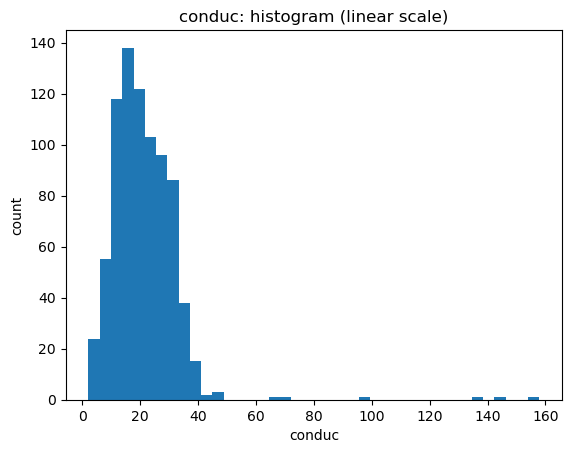

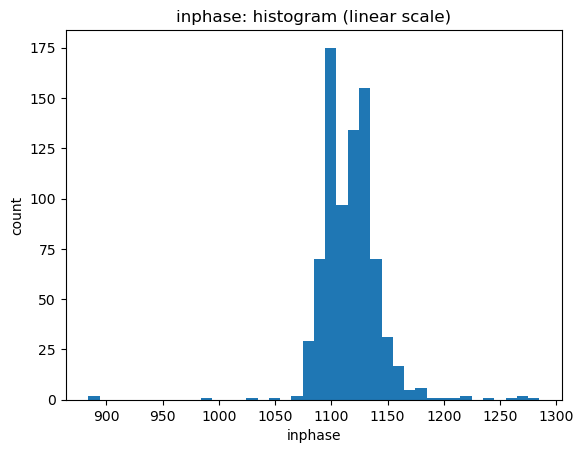

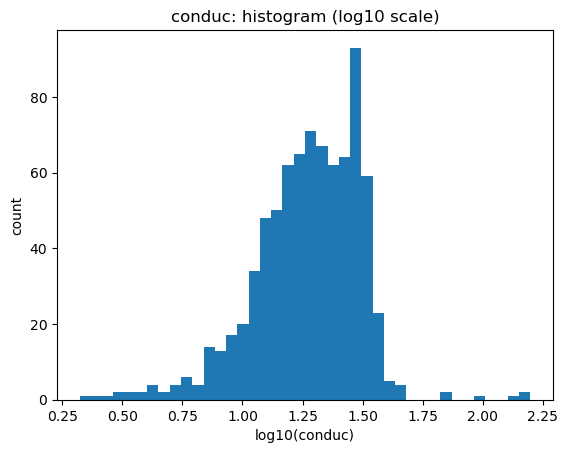

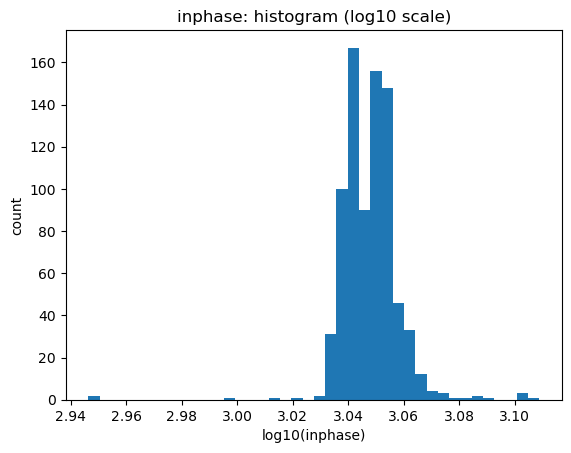

In [6]:
em_cols = ["conduc", "inphase"]

# Work on valid rows only for univariate summaries (no imputation)
df_em = df.dropna(subset=em_cols).copy()

print(f"Total rows: {len(df):,}")
print(f"Rows with valid conduc & inphase: {len(df_em):,}")
display(df[em_cols].isna().sum().to_frame("missing_count"))

# --- Summary statistics ---
def robust_summary(s: pd.Series) -> pd.Series:
    s = s.dropna()
    return pd.Series({
        "count": s.size,
        "mean": s.mean(),
        "std": s.std(ddof=1),
        "min": s.min(),
        "p05": s.quantile(0.05),
        "p25": s.quantile(0.25),
        "median": s.median(),
        "p75": s.quantile(0.75),
        "p95": s.quantile(0.95),
        "max": s.max(),
        "iqr": s.quantile(0.75) - s.quantile(0.25),
        "skew": s.skew(),
        "kurtosis_excess": s.kurtosis(),  # pandas returns excess kurtosis by default
    })

summary_tbl = pd.concat(
    {col: robust_summary(df[col]) for col in em_cols},
    axis=1
)

display(summary_tbl)

# --- Histograms (linear scale) ---
for col in em_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=40)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"{col}: histogram (linear scale)")
    plt.show()

# --- Histograms (log scale if positive and skewed) ---
# Conductivity should be positive; log view helps if heavy right tail.
# In-phase may include zeros/negatives depending on instrument/reporting; only log if strictly positive.
for col in em_cols:
    s = df[col].dropna()
    if (s > 0).all():
        plt.figure()
        plt.hist(np.log10(s), bins=40)
        plt.xlabel(f"log10({col})")
        plt.ylabel("count")
        plt.title(f"{col}: histogram (log10 scale)")
        plt.show()
    else:
        print(f"Skipping log-scale histogram for {col}: contains non-positive values.")

Univariate summaries highlight markedly different distributional behavior between the two EM31 channels. Conductivity exhibits strong right skew (skew ≈ 4.8) and extremely heavy tails (excess kurtosis ≈ 46), with a small number of localized high values dominating the variance. This behavior is consistent with heterogeneous landfill materials and near-surface metallic debris, and motivates transformation or robust treatment prior to geostatistical modeling. In contrast, in-phase responses show a much tighter central distribution with only mild skew, though heavy tails remain present. These distributional properties inform subsequent choices around variogram fitting, uncertainty estimation, and exceedance probability calculations.


### 3.4 Spatial Distribution of Raw Measurements

Spatial plots of the raw EM31 measurements are examined to identify large-scale trends, localized clustering, and potential survey artifacts prior to variogram modeling. Visual inspection at this stage helps distinguish systematic spatial structure from isolated outliers and informs subsequent checks for anisotropy and nonstationarity. Because conductivity values exhibit strong right skew and heavy tails, direct linear color scaling obscures spatial structure by compressing most observations into a narrow visual range. To improve interpretability while preserving relative spatial patterns, conductivity maps are displayed using a percentile-clipped color scale (5th–95th percentile). This adjustment is applied **for visualization purposes only**; all subsequent analyses use the full, unmodified data values.

Both conductivity and in-phase values are plotted at their measurement locations using a consistent spatial reference. These maps are used qualitatively to assess whether extreme values are spatially coherent, line-associated, or randomly distributed.

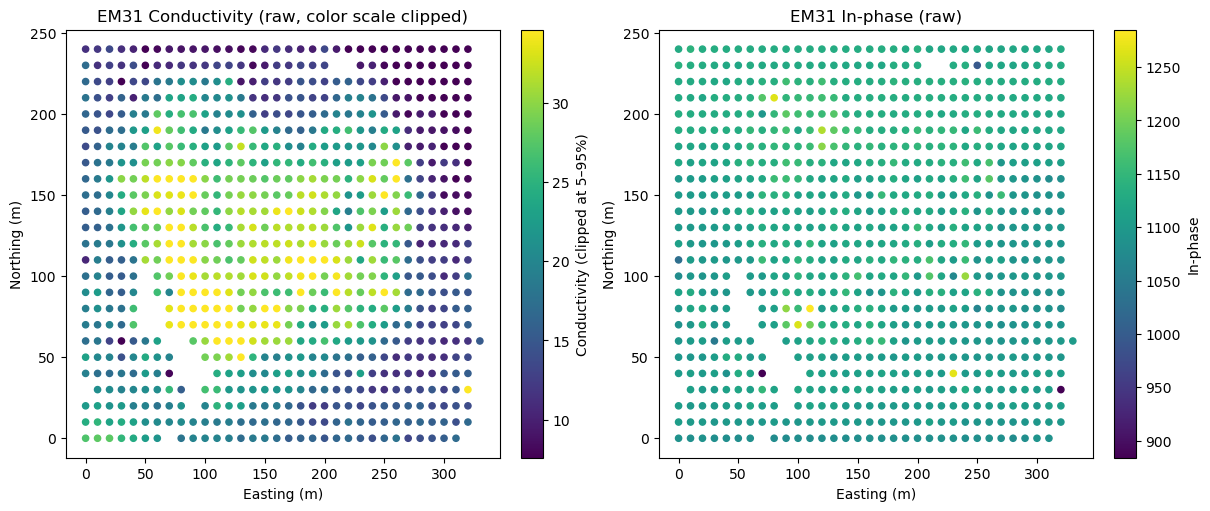

In [7]:
# 3.4 Spatial distribution of raw measurements

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Conductivity map

vmin = df_em["conduc"].quantile(0.05)
vmax = df_em["conduc"].quantile(0.95)

sc1 = axes[0].scatter(
    df_em["easting"],
    df_em["northing"],
    c=df_em["conduc"],
    s=20,
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title("EM31 Conductivity (raw, color scale clipped)")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
plt.colorbar(sc1, ax=axes[0], label="Conductivity (clipped at 5–95%)")

# In-phase map

sc2 = axes[1].scatter(
    df_em["easting"],
    df_em["northing"],
    c=df_em["inphase"],
    s=20
)
axes[1].set_title("EM31 In-phase (raw)")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
plt.colorbar(sc2, ax=axes[1], label="In-phase")

plt.show()


To improve visual contrast, conductivity color scales are clipped at the 5th–95th percentile for display only; all analyses use the full unmodified data values.  The top-5% values are highlighted next.

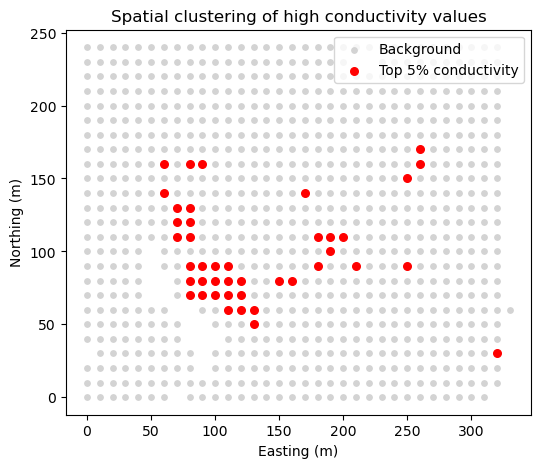

In [8]:
# Highlight top 5% conductivity values

thr = df_em["conduc"].quantile(0.95)

plt.figure(figsize=(6, 5))
plt.scatter(
    df_em["easting"],
    df_em["northing"],
    c="lightgray",
    s=15,
    label="Background"
)

plt.scatter(
    df_em.loc[df_em["conduc"] >= thr, "easting"],
    df_em.loc[df_em["conduc"] >= thr, "northing"],
    c="red",
    s=30,
    label="Top 5% conductivity"
)

plt.title("Spatial clustering of high conductivity values")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()


Visual inspection of the raw spatial distributions highlights distinct differences between the two EM31 channels. Elevated conductivity values occur primarily in a small number of tightly clustered zones rather than as isolated point anomalies, suggesting coherent subsurface features rather than random measurement noise or single-point artifacts. In contrast, high in-phase responses are more broadly distributed across the site, though several in-phase maxima are co-located with conductivity clusters.

Highlighting the upper tail of the conductivity distribution (e.g., values above the 95th percentile) reinforces the presence of spatially coherent anomalous regions while preserving broader contextual structure. More extreme thresholds isolate a small subset of points but discard spatial continuity, motivating the use of geostatistical modeling to balance localization with uncertainty-aware interpretation.

These observations support further spatial analysis and motivate subsequent evaluation of inter-channel relationships, anisotropy, and spatial correlation structure prior to interpolation.


### 3.5 Relationship Between Conductivity and In-Phase Responses

Conductivity and in-phase responses are derived from the same EM31 measurements but reflect different aspects of the subsurface electromagnetic response. Examining their relationship helps assess whether the two channels provide largely redundant information or capture complementary signals at different spatial scales.

In this section, pairwise relationships between conductivity and in-phase values are evaluated using scatter plots and summary correlation metrics. These analyses are used to assess the strength and form of inter-channel association and to identify whether elevated responses tend to co-occur spatially.

The results inform subsequent modeling choices, including whether independent spatial modeling is appropriate for each channel or whether joint approaches (e.g., co-kriging or multivariate methods) would be warranted in a production setting. At this exploratory stage, the analysis remains descriptive and is used to guide interpretation rather than impose modeling constraints.


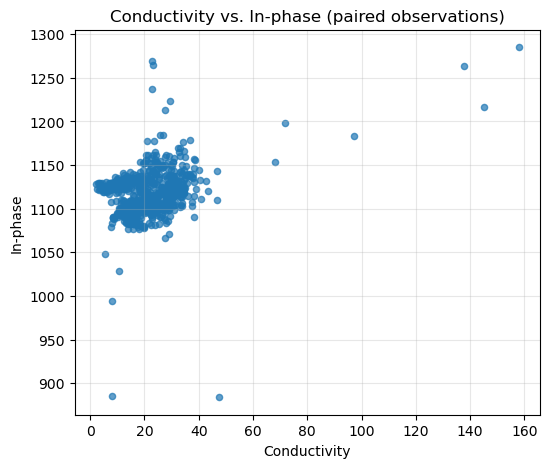

Correlation metrics:
Pearson r   = 0.372 (p = 7.85e-28)
Spearman ρ = 0.249 (p = 7.97e-13)


In [9]:
# Ensure paired, valid observations
df_pair = df_em[["conduc", "inphase"]].dropna()

# --- Scatter plot ---
plt.figure(figsize=(6, 5))
plt.scatter(
    df_pair["conduc"],
    df_pair["inphase"],
    s=20,
    alpha=0.7
)
plt.xlabel("Conductivity")
plt.ylabel("In-phase")
plt.title("Conductivity vs. In-phase (paired observations)")
plt.grid(True, alpha=0.3)
plt.show()

# --- Correlation metrics ---
pearson_r, pearson_p = pearsonr(df_pair["conduc"], df_pair["inphase"])
spearman_r, spearman_p = spearmanr(df_pair["conduc"], df_pair["inphase"])

print("Correlation metrics:")
print(f"Pearson r   = {pearson_r:.3f} (p = {pearson_p:.2e})")
print(f"Spearman ρ = {spearman_r:.3f} (p = {spearman_p:.2e})")

Paired analysis of conductivity and in-phase responses indicates a statistically significant but moderate association between the two EM31 channels (Pearson r ≈ 0.37; Spearman ρ ≈ 0.25). The difference between linear and rank-based correlation metrics reflects the strongly skewed conductivity distribution and the influence of a small number of extreme values.

The scatter plot shows a dense background population with weak overall correlation, alongside a subset of higher-conductivity observations where in-phase values tend to be elevated. This pattern is consistent with the two channels capturing related but not redundant aspects of the subsurface electromagnetic response: conductivity anomalies are often accompanied by elevated in-phase responses, but elevated in-phase values also occur in isolation.

These results support treating conductivity and in-phase as complementary indicators rather than interchangeable measures. For the purposes of this analysis, the channels are modeled independently to preserve interpretability. In a production setting, the observed inter-channel association motivates consideration of joint approaches such as co-kriging or multivariate spatial models to more efficiently leverage shared information.


## 4. Spatial Correlation and Variogram Modeling

This section characterizes the spatial correlation structure of the EM31 conductivity and in-phase measurements using empirical variograms. Variograms provide a quantitative description of how similarity between measurements decays with distance and form the foundation for subsequent spatial interpolation and uncertainty-aware mapping.

We begin by computing omnidirectional empirical variograms using all point pairs within defined lag bins, leveraging the regular ~10 m sampling of the survey to obtain stable short-range estimates. Candidate theoretical variogram models are then fitted to the empirical curves to estimate key parameters, including the nugget (representing measurement error and sub-grid variability), the sill (total variance), and the effective range (distance beyond which measurements are effectively uncorrelated).

Where appropriate, alternative data transforms and model forms are evaluated to account for heavy-tailed distributions and to ensure that the fitted variograms reflect physically meaningful spatial structure rather than noise or large-scale trends. These fitted models are subsequently used to inform kriging-based interpolation and downstream spatial decision analyses.

Point count used for variograms: 806
Site extent: dx=330.0 m, dy=240.0 m; using max_lag=160.0 m, lag=10.0 m


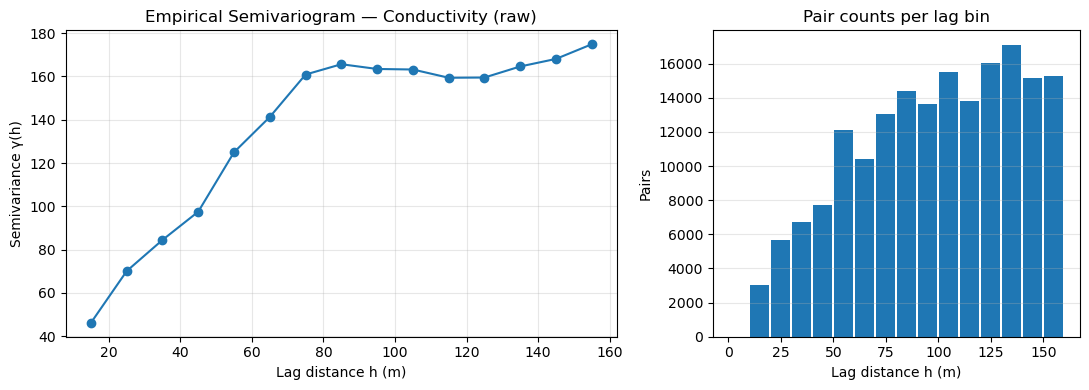

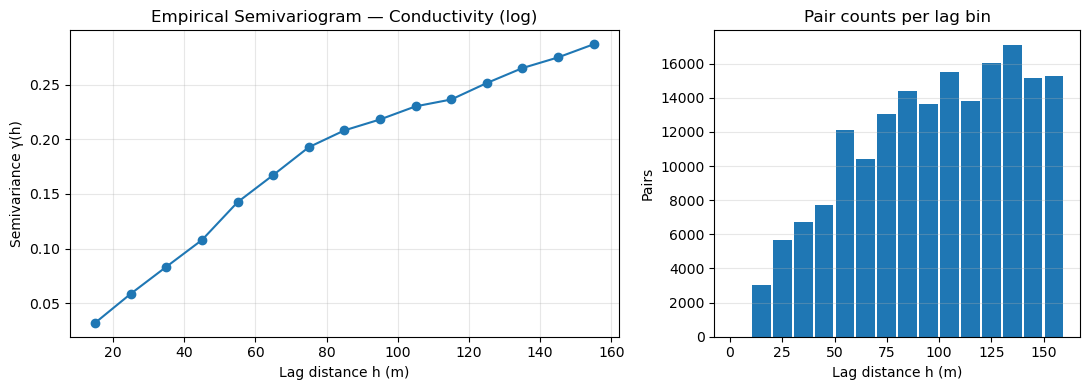

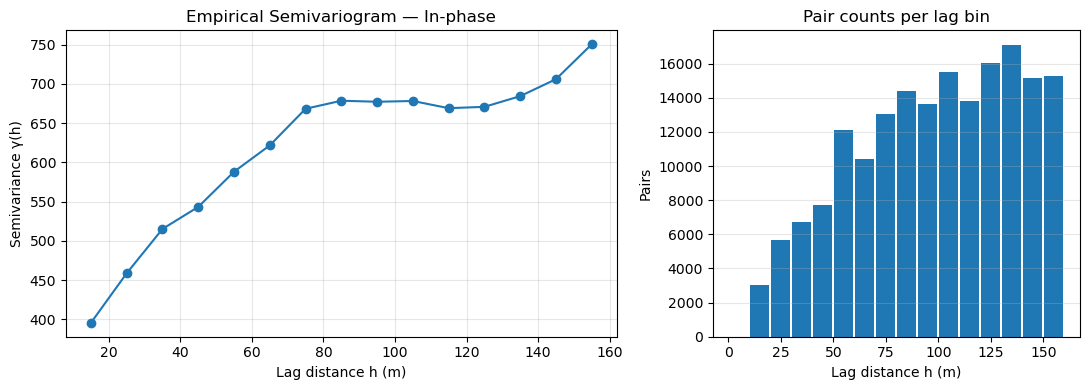

In [10]:
# --- Section 4.2: Empirical variograms (conductivity: raw + log) ---

# Expectation: df_em already has numeric columns 'conduc' and 'inphase'
# and missing values have been coerced to NaN.
df_vg = df_em[["easting", "northing", "conduc", "inphase"]].dropna().copy()

# Conductivity on raw + log scales (log is helpful for heavy-tailed distributions)
df_vg["conduc_raw"] = df_vg["conduc"].astype(float)
df_vg["conduc_log"] = np.log(df_vg["conduc_raw"])  # conductivity is > 0 here

# Coordinates
coords = df_vg[["easting", "northing"]].to_numpy(dtype=float)

# Choose lag parameters based on survey geometry
# - lag ~ sampling spacing (10 m)
# - max_lag ~ ~1/2 of max site dimension (or until variogram stabilizes)
lag = 10.0
dx = df_vg["easting"].max() - df_vg["easting"].min()
dy = df_vg["northing"].max() - df_vg["northing"].min()
max_dim = float(max(dx, dy))
max_lag = lag * np.floor((0.5 * max_dim) / lag)  # snap to lag grid

print(f"Point count used for variograms: {len(df_vg)}")
print(f"Site extent: dx={dx:.1f} m, dy={dy:.1f} m; using max_lag={max_lag:.1f} m, lag={lag:.1f} m")

def empirical_variogram(coords: np.ndarray, values: np.ndarray, lag: float, max_lag: float):
    """
    Omnidirectional empirical semivariogram using all unique point pairs.
    Returns: bin_centers, gamma(h), pair_counts
    """
    coords = np.asarray(coords, dtype=float)
    z = np.asarray(values, dtype=float)

    # Pairwise distances (condensed vector) and squared differences
    h = pdist(coords, metric="euclidean")  # size ~ n(n-1)/2
    dz = pdist(z.reshape(-1, 1), metric="euclidean")  # abs diffs
    dz2 = dz ** 2

    # Lag bins
    edges = np.arange(0.0, max_lag + lag, lag)
    bin_idx = np.digitize(h, edges) - 1  # bins 0..len(edges)-2
    valid = (bin_idx >= 0) & (bin_idx < (len(edges) - 1))
    bin_idx = bin_idx[valid]
    dz2 = dz2[valid]

    nbins = len(edges) - 1
    counts = np.bincount(bin_idx, minlength=nbins)

    # Sum of squared diffs per bin (use bincount weights)
    sum_dz2 = np.bincount(bin_idx, weights=dz2, minlength=nbins)

    # Semivariance: 0.5 * mean squared difference
    gamma = np.full(nbins, np.nan, dtype=float)
    nonzero = counts > 0
    gamma[nonzero] = 0.5 * (sum_dz2[nonzero] / counts[nonzero])

    # Bin centers
    centers = 0.5 * (edges[:-1] + edges[1:])
    return centers, gamma, counts

# Compute empirical variograms
vg = {}
for name in ["conduc_raw", "conduc_log", "inphase"]:
    centers, gamma, counts = empirical_variogram(coords, df_vg[name].to_numpy(), lag=lag, max_lag=max_lag)
    vg[name] = {"h": centers, "gamma": gamma, "counts": counts}

# --- Combined variogram + pair-count plots ---

def plot_variogram_and_counts(h, gamma, counts, lag, title, y_label):
    fig, axes = plt.subplots(
        ncols=2, figsize=(11, 4),
        gridspec_kw={"width_ratios": [3, 2]}
    )

    # Semivariogram
    axes[0].plot(h, gamma, marker="o", linestyle="-")
    axes[0].set_title(title)
    axes[0].set_xlabel("Lag distance h (m)")
    axes[0].set_ylabel(y_label)
    axes[0].grid(True, alpha=0.3)

    # Pair counts
    axes[1].bar(h, counts, width=lag * 0.9)
    axes[1].set_title("Pair counts per lag bin")
    axes[1].set_xlabel("Lag distance h (m)")
    axes[1].set_ylabel("Pairs")
    axes[1].grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


# --- Conductivity (raw) ---
plot_variogram_and_counts(
    vg["conduc_raw"]["h"],
    vg["conduc_raw"]["gamma"],
    vg["conduc_raw"]["counts"],
    lag=lag,
    title="Empirical Semivariogram — Conductivity (raw)",
    y_label="Semivariance γ(h)"
)

# --- Conductivity (log) ---
plot_variogram_and_counts(
    vg["conduc_log"]["h"],
    vg["conduc_log"]["gamma"],
    vg["conduc_log"]["counts"],
    lag=lag,
    title="Empirical Semivariogram — Conductivity (log)",
    y_label="Semivariance γ(h)"
)

# --- In-phase ---
plot_variogram_and_counts(
    vg["inphase"]["h"],
    vg["inphase"]["gamma"],
    vg["inphase"]["counts"],
    lag=lag,
    title="Empirical Semivariogram — In-phase",
    y_label="Semivariance γ(h)"
)


### Empirical Variogram Interpretation

The empirical semivariograms reveal clear and physically plausible spatial structure in both EM31 conductivity and in-phase measurements. Conductivity exhibits a well-defined increase in semivariance with lag distance, reaching an effective sill at approximately 80–100 m. This indicates strong local spatial continuity consistent with clustered conductive features rather than random noise. The non-zero semivariance at short lags reflects a combination of instrument noise, positioning uncertainty, and sub-grid heterogeneity.

Applying a logarithmic transform to conductivity produces a smoother, more monotonic variogram with reduced influence from extreme values, supporting the use of the transformed variable for subsequent spatial modeling and interpolation.

The in-phase component displays a similar correlation length but with a higher nugget and overall variance, reflecting its greater sensitivity to discrete metallic objects and localized coupling effects. Despite this increased variability, the in-phase measurements retain meaningful spatial coherence at the site scale.

Across all variables, pair counts per lag bin are large and well-distributed, indicating that the empirical variograms are statistically stable and suitable for fitting theoretical models to support kriging-based interpolation.

### 4.3 Variogram Model Fitting

To support kriging-based interpolation, theoretical variogram models were fitted to the empirical semivariograms derived in the previous section. Model selection prioritized physical plausibility, parsimony, and interpretability over purely numerical goodness-of-fit.

Given the localized nature of the survey area and the observed behavior of the empirical curves, spherical and exponential models were considered most appropriate. These models capture finite-range spatial correlation and are commonly used for near-surface environmental and geophysical data.

Variogram parameters—including nugget, sill, and effective range—were estimated by visually matching the theoretical models to the empirical semivariograms, with particular emphasis on the short- to mid-range lags where spatial dependence is strongest and pair counts are highest. For conductivity, both raw and log-transformed data were evaluated; the log-transformed conductivity produced a smoother variogram and was selected for subsequent spatial interpolation.

The fitted variogram models provide a compact description of spatial continuity at the site scale and form the basis for kriging predictions and uncertainty assessment in later sections.


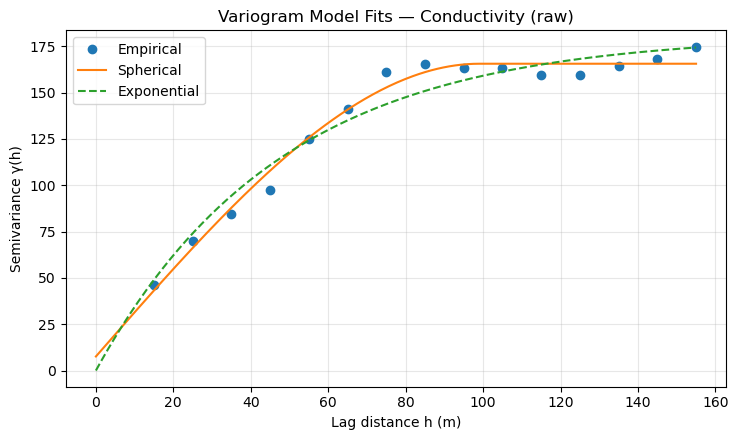

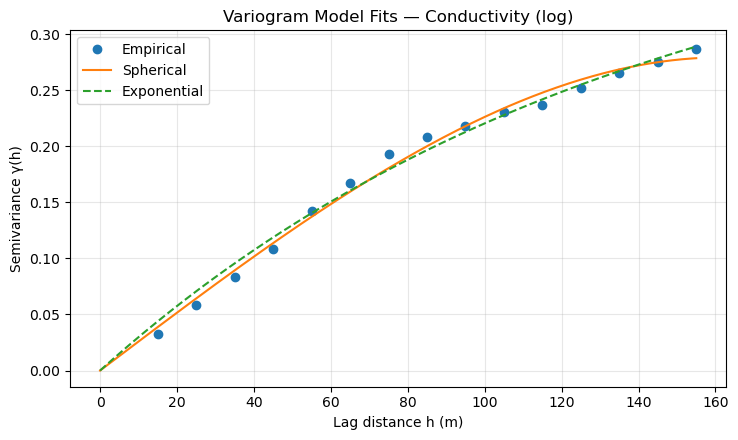

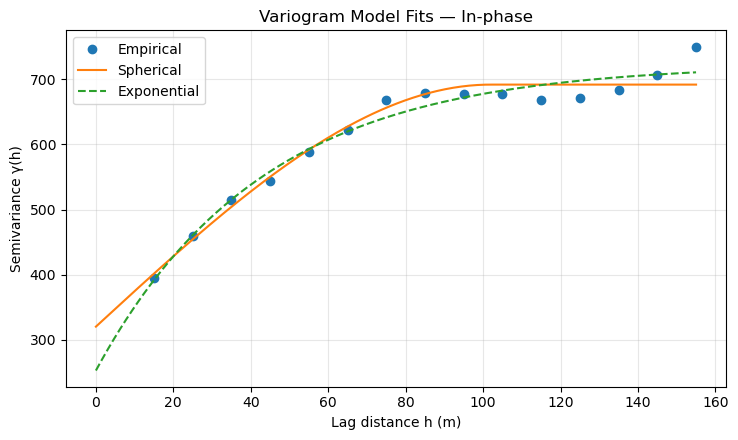

,variable,model,nugget,sill(plateau),nugget_fraction,range_param_m,practical_range_m
3,Conductivity (log),exponential,2.746370e-11,0.430529,6.379063e-11,139.422020,418.266060
2,Conductivity (log),spherical,3.593855e-07,0.279173,1.287321e-06,161.521018,161.521018
1,Conductivity (raw),exponential,1.769207e-13,181.368262,9.754777e-16,47.630709,142.892127
0,Conductivity (raw),spherical,7.590558e+00,165.608605,4.583432e-02,99.011569,99.011569
5,In-phase,exponential,2.529513e+02,723.504010,3.496198e-01,42.906965,128.720895
4,In-phase,spherical,3.203490e+02,691.958672,4.629598e-01,101.940653,101.940653


In [11]:
# Variogram model definitions
def spherical(h, nugget, sill, rng):
    h = np.asarray(h, dtype=float)
    rng = max(float(rng), 1e-9)
    hr = h / rng
    core = 1.5 * hr - 0.5 * (hr ** 3)
    return np.where(h <= rng, nugget + (sill - nugget) * core, nugget + (sill - nugget))

def exponential(h, nugget, sill, rng):
    h = np.asarray(h, dtype=float)
    rng = max(float(rng), 1e-9)
    return nugget + (sill - nugget) * (1.0 - np.exp(-h / rng))

def fit_model(h, gamma, model_func):
    mask = np.isfinite(gamma)
    h_fit = np.asarray(h)[mask]
    g_fit = np.asarray(gamma)[mask]

    nugget0 = float(g_fit[0])
    sill0 = float(np.nanmax(g_fit))
    idx = np.where(g_fit >= nugget0 + 0.9 * (sill0 - nugget0))[0]
    rng0 = float(h_fit[idx[0]]) if len(idx) else float(h_fit.max())

    popt, _ = curve_fit(
        model_func, h_fit, g_fit,
        p0=[nugget0, sill0, rng0],
        bounds=([0, 0, 1e-6], [np.inf, np.inf, np.inf]),
        maxfev=20000
    )
    return popt

variables = {
    "conduc_raw": "Conductivity (raw)",
    "conduc_log": "Conductivity (log)",
    "inphase": "In-phase"
}

fitted_params = {}

rows = []
for key, label in variables.items():
    h = vg[key]["h"]
    g = vg[key]["gamma"]

    p_sph = fit_model(h, g, spherical)
    p_exp = fit_model(h, g, exponential)

    fitted_params[key] = {"spherical": p_sph, "exponential": p_exp}

    # simple diagnostics for discussion
    for model_name, p in [("spherical", p_sph), ("exponential", p_exp)]:
        nugget, sill, rng = p
        rows.append({
            "variable": label,
            "model": model_name,
            "nugget": nugget,
            "sill(plateau)": sill,
            "nugget_fraction": nugget / sill if sill > 0 else np.nan,
            "range_param_m": rng,
            "practical_range_m": (3*rng if model_name == "exponential" else rng)
        })

    # plot
    h_dense = np.linspace(0, np.nanmax(h), 300)
    plt.figure(figsize=(7.5, 4.5))
    plt.plot(h, g, "o", label="Empirical")
    plt.plot(h_dense, spherical(h_dense, *p_sph), "-", label="Spherical")
    plt.plot(h_dense, exponential(h_dense, *p_exp), "--", label="Exponential")
    plt.title(f"Variogram Model Fits — {label}")
    plt.xlabel("Lag distance h (m)")
    plt.ylabel("Semivariance γ(h)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

df_fit_summary = pd.DataFrame(rows)
display(df_fit_summary.sort_values(["variable", "model"]))

### Variogram Model Selection and Implications

Across all variables, both spherical and exponential models provide reasonable fits to the empirical semivariograms, with broadly consistent estimates of spatial correlation length at the site scale. For conductivity, the log-transformed data yield a smoother variogram with a negligible nugget fraction and a longer effective range, indicating improved stationarity and reduced influence from extreme values. This supports the use of log conductivity as the primary variable for spatial interpolation.

The in-phase component exhibits substantially higher nugget fractions, reflecting greater sensitivity to localized metallic objects, instrument coupling effects, and sub-grid variability. Nevertheless, its fitted range is comparable to that of conductivity, indicating meaningful spatial coherence at similar length scales despite increased local noise.

Given these results, spherical variogram models are adopted for subsequent kriging due to their finite-range behavior and interpretability. The fitted models provide a compact, physically plausible description of spatial continuity and serve as the foundation for spatial prediction and uncertainty-aware mapping in the following section.

## 4.4 Assumptions and Modeling Considerations

The variogram analysis and subsequent kriging rely on several standard assumptions that are evaluated here in the context of the survey design and data characteristics.

#### Second-order stationarity.
The variogram models assume that spatial dependence depends only on separation distance and not on absolute location within the site. While environmental data at landfill sites may exhibit large-scale trends related to site geometry or historical disposal practices, exploratory analysis did not indicate a strong monotonic spatial drift over the survey extent. Given the relatively compact site footprint and the focus on local-scale variability (tens of meters), the assumption of local stationarity is considered reasonable for this analysis.

#### Isotropy.
Omnidirectional variograms were used, implicitly assuming that spatial correlation is similar in all directions. Although the survey was conducted along approximately regular east–west traverses, the empirical variograms exhibit smooth behavior and stable pair counts across lags, suggesting that isotropic models provide an adequate first-order description of spatial continuity. Directional anisotropy could be explored in a production setting, but isotropic models are sufficient for the present demonstration.

#### Measurement error and nugget effect.
Non-zero nugget terms reflect a combination of instrument noise, positioning uncertainty from consumer-grade GPS, and sub-grid heterogeneity at scales smaller than the 10 m sampling interval. The relative magnitude of the nugget varies by variable, with substantially higher nugget fractions observed for the in-phase component, consistent with its sensitivity to discrete metallic objects and localized coupling effects.

#### Distributional assumptions.
Kriging assumes approximate normality of residuals. Raw conductivity values are heavy-tailed; applying a logarithmic transform produces a more stable distribution and smoother variogram, supporting its use as the primary kriging variable. In-phase values are modeled on their native scale, with the understanding that increased local variability may limit fine-scale predictive precision.

Taken together, these considerations indicate that the fitted variogram models provide a reasonable and physically interpretable basis for kriging-based spatial prediction, while highlighting areas where additional refinement could be pursued in a production or regulatory workflow.

## 5. Kriging and Spatial Prediction

This section applies the fitted variogram models to generate spatial predictions of EM31 responses across the survey area using ordinary kriging. Kriging provides best linear unbiased estimates of the underlying spatial fields by weighting nearby observations according to the modeled spatial correlation structure.

Log-transformed conductivity is treated as the primary variable for interpolation due to its smoother variogram, reduced influence of extreme values, and improved stationarity. The in-phase component is modeled separately to provide complementary spatial information, with the understanding that its higher nugget fraction limits fine-scale predictive precision.

Predictions are generated on a regular 10 m grid, matching the original sampling spacing and avoiding overinterpretation of spatial detail beyond the information content of the data. In addition to prediction surfaces, kriging variance maps are produced to characterize the geometric uncertainty associated with data spacing and variogram structure. These variance estimates are interpreted cautiously and serve as inputs to subsequent, decision-oriented analyses rather than as direct measures of prediction error.

### 5.1 Kriging Setup

Spatial interpolation is performed using ordinary kriging, which assumes an unknown but locally constant mean and is appropriate for near-surface environmental and geophysical data where large-scale deterministic trends are not explicitly modeled. Ordinary kriging provides a flexible and widely used framework for estimating spatially correlated fields while honoring observed data values.

Kriging is carried out in a local Cartesian coordinate system (meters), using Euclidean distances derived from the survey grid. The fitted spherical variogram models from Section 4 are used to define spatial covariance for each variable. Log-transformed conductivity is treated as the primary kriging variable, while the in-phase component is modeled separately to support comparative interpretation. Multivariate approaches such as cokriging are not applied here and are deferred to potential future work.

All kriging parameters—including variogram model form and range—are held fixed during interpolation to maintain consistency with the previously validated spatial correlation analysis.

### 5.2 Prediction Grid Definition

Spatial predictions are generated on a regular two-dimensional grid covering the extent of the survey area. The grid is defined in the same local Cartesian coordinate system as the input data, with axes aligned to the original east–north survey coordinates.

A 10 m grid spacing is used for all kriging predictions, matching the nominal field sampling interval. This resolution avoids introducing apparent spatial detail beyond the information content of the data while providing sufficient granularity to resolve features at the scale indicated by the fitted variogram ranges. Predictions near the edges of the grid and in areas with sparse data support are interpreted with appropriate caution.

The resulting grid provides a consistent spatial framework for generating kriging prediction and variance surfaces and for subsequent decision-oriented analyses.

### 5.3 Kriging with PyKrige

Points used for kriging: 806
Grid: 34 x 25 = 850 cells @ 10 m

PyKrige variogram params (spherical):
  Conductivity (log): partial_sill=0.2792, range=161.52, nugget=3.594e-07
  In-phase:           partial_sill=371.6, range=101.94, nugget=320.3


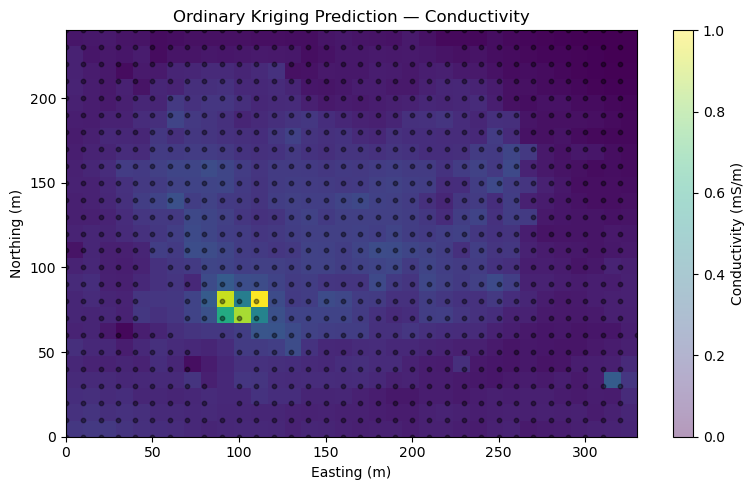

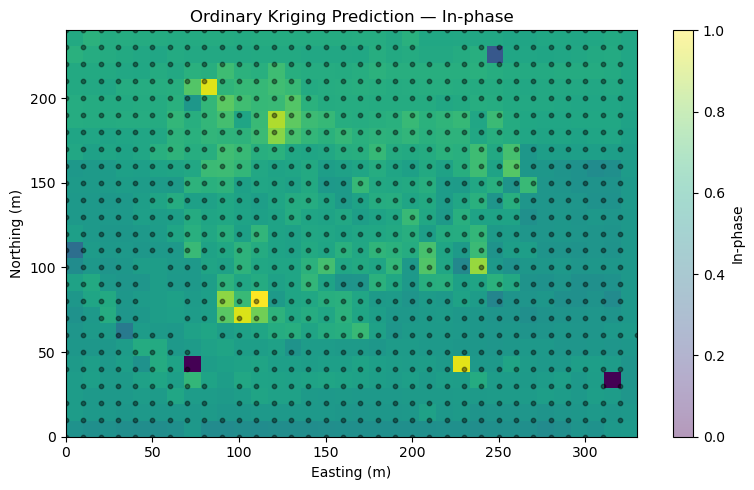

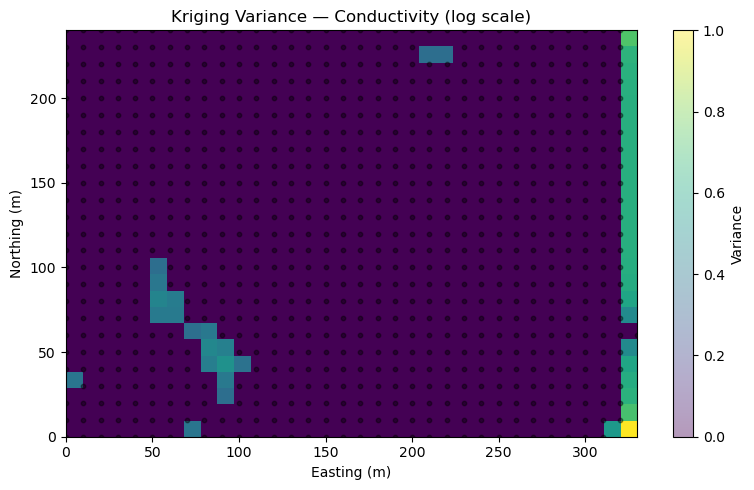

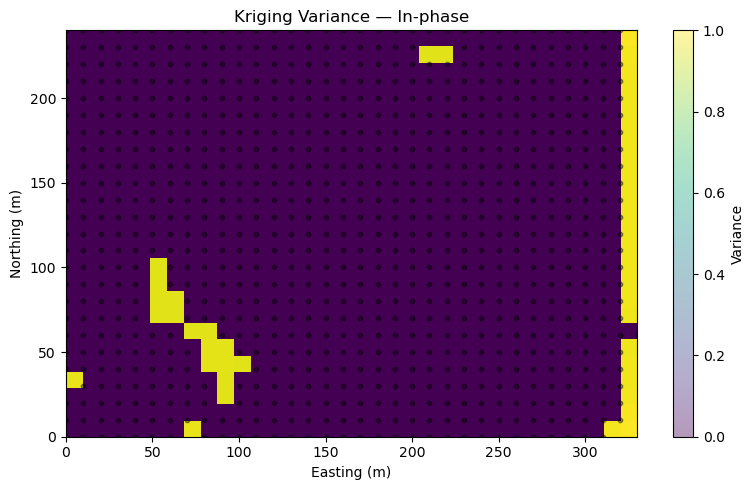

In [12]:

# 1) Prepare input data

# Use the cleaned analysis dataframe (drop missing)
df_k = df_em[["easting", "northing", "conduc", "inphase"]].dropna().copy()

x = df_k["easting"].to_numpy(dtype=float)
y = df_k["northing"].to_numpy(dtype=float)

# Primary variable: log conductivity
z_conduc_log = np.log(df_k["conduc"].to_numpy(dtype=float))

# Secondary variable: in-phase (native scale)
z_inphase = df_k["inphase"].to_numpy(dtype=float)


# 2) Define prediction grid (10 m)

grid_res = 10.0

x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

gridx = np.arange(x_min, x_max + grid_res, grid_res)
gridy = np.arange(y_min, y_max + grid_res, grid_res)

print(f"Points used for kriging: {len(df_k)}")
print(f"Grid: {len(gridx)} x {len(gridy)} = {len(gridx)*len(gridy)} cells @ {grid_res:.0f} m")


# 3) Variogram parameters (from Section 4 fits)

# Use the spherical fits

params_conduc_log_sph = fitted_params["conduc_log"]["spherical"]
params_inphase_sph    = fitted_params["inphase"]["spherical"]

# PyKrige expects variogram_parameters for built-in models as: [sill, range, nugget]
# where "sill" here is the *partial sill* (structured component),
# and the total plateau is (partial_sill + nugget).
#
# Our fitted parameterization was: (nugget, sill_plateau, range)
# so partial_sill = sill_plateau - nugget

def to_pykrige_params(p):
    nugget, sill_plateau, rng = p
    partial_sill = max(float(sill_plateau - nugget), 1e-12)
    return [partial_sill, float(rng), float(nugget)]

vk_conduc_log = to_pykrige_params(params_conduc_log_sph)
vk_inphase    = to_pykrige_params(params_inphase_sph)

print("\nPyKrige variogram params (spherical):")
print(f"  Conductivity (log): partial_sill={vk_conduc_log[0]:.4g}, range={vk_conduc_log[1]:.2f}, nugget={vk_conduc_log[2]:.4g}")
print(f"  In-phase:           partial_sill={vk_inphase[0]:.4g}, range={vk_inphase[1]:.2f}, nugget={vk_inphase[2]:.4g}")


# 4) Ordinary Kriging (OK)

# Conductivity (log)
ok_conduc = OrdinaryKriging(
    x, y, z_conduc_log,
    variogram_model="spherical",
    variogram_parameters=vk_conduc_log,
    enable_plotting=False,
    verbose=False
)

z_conduc_log_hat, var_conduc_log = ok_conduc.execute("grid", gridx, gridy)

# In-phase
ok_inphase = OrdinaryKriging(
    x, y, z_inphase,
    variogram_model="spherical",
    variogram_parameters=vk_inphase,
    enable_plotting=False,
    verbose=False
)

z_inphase_hat, var_inphase = ok_inphase.execute("grid", gridx, gridy)

# Convert masked arrays -> ndarray with NaNs
z_conduc_log_hat = np.asarray(z_conduc_log_hat, dtype=float)
var_conduc_log   = np.asarray(var_conduc_log, dtype=float)

z_inphase_hat = np.asarray(z_inphase_hat, dtype=float)
var_inphase   = np.asarray(var_inphase, dtype=float)

# Back-transform conductivity predictions to original units (optional but often useful)
z_conduc_hat = np.exp(z_conduc_log_hat)


# 5) Quick visualization helpers

def plot_grid(gridx, gridy, Z, title, cbar_label):
    plt.figure(figsize=(8, 5))
    plt.imshow(
        Z,
        origin="lower",
        extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()],
        aspect="auto"
    )
    plt.scatter(x, y, s=10, c="k", alpha=0.4, label="Samples")
    plt.title(title)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    cbar = plt.colorbar()
    cbar.set_label(cbar_label)
    plt.tight_layout()
    plt.show()

# Prediction surfaces
plot_grid(gridx, gridy, z_conduc_hat, "Ordinary Kriging Prediction — Conductivity", "Conductivity (mS/m)")
plot_grid(gridx, gridy, z_inphase_hat, "Ordinary Kriging Prediction — In-phase", "In-phase")

# Kriging variance surfaces (geometric uncertainty)
plot_grid(gridx, gridy, var_conduc_log, "Kriging Variance — Conductivity (log scale)", "Variance")
plot_grid(gridx, gridy, var_inphase, "Kriging Variance — In-phase", "Variance")

### 5.4 Interpretation of Kriging Results

The ordinary kriging results reveal a spatially coherent conductivity anomaly located within the central portion of the survey area, characterized by moderately elevated background values and a single, compact high-conductivity “hot spot.” This anomaly is well resolved relative to surrounding background conditions and is supported by multiple nearby observations rather than isolated measurements.

The in-phase kriging surface exhibits a localized high-amplitude response that is spatially co-located with the primary conductivity anomaly. Because the conductivity and in-phase channels reflect distinct physical sensitivities of the EM31 instrument, their spatial agreement increases confidence that the observed feature represents a real subsurface contrast rather than an interpolation artifact or random measurement noise.

Kriging variance behaves as expected given the survey geometry and data density. Variance is lowest across the well-sampled interior of the grid and increases near survey boundaries and in regions where observations are sparse or missing. Importantly, the primary conductivity and in-phase anomalies do not coincide with areas of elevated kriging variance, indicating that these features are constrained by nearby data and not driven by geometric uncertainty.

Overall, the kriging results support the presence of a localized subsurface feature associated with landfill materials, expressed consistently across independent EM31 response channels. Interpretation is intentionally limited to spatial patterns and relative contrasts; no claims are made regarding material composition, depth, or regulatory significance.

### 5.5 Transition to Decision-Oriented Analysis

The kriging results presented above provide continuous spatial estimates of EM31 conductivity and in-phase response, along with geometry-driven measures of interpolation uncertainty. While these surfaces are useful for visualizing spatial patterns and identifying candidate anomalies, they are not directly actionable on their own.

Practical decision-making—such as prioritizing follow-up sampling, delineating targets, or allocating field resources—requires reframing these continuous predictions in probabilistic and comparative terms. In particular, decisions are typically based not on predicted values alone, but on the likelihood that a location exceeds a meaningful threshold and on the confidence associated with that assessment.

The following section therefore shifts from interpolation to decision framing. Rather than treating kriging outputs as final answers, they are used as inputs to a calibrated uncertainty model that supports probability-of-exceedance mapping and explicit trade-offs between coverage, confidence, and risk. This transition reflects the broader goal of using spatial models not merely to describe the subsurface, but to guide efficient and defensible field decisions.

## 6. Probability of Exceedance and Uncertainty Calibration

Spatial interpolation alone does not provide a sufficient basis for decision-making in environmental or exploration contexts. Actions such as follow-up sampling, infill surveying, or anomaly prioritization depend not only on predicted values, but on the likelihood that those values exceed a threshold of interest and on the reliability of that assessment.

In this section, kriging predictions are reframed in probabilistic terms by estimating the probability of exceedance for selected thresholds. Because kriging variance reflects only geometric uncertainty associated with data configuration and variogram structure, it is not treated as a direct measure of prediction error. Instead, uncertainty is calibrated empirically using spatial cross-validation to capture local model misfit, unresolved heterogeneity, and other sources of epistemic uncertainty.

The resulting probability-of-exceedance maps are therefore interpreted as decision-support tools, not definitive confidence statements. Their purpose is to identify spatial patterns, prioritize areas for further investigation, and illustrate how uncertainty-aware modeling can guide efficient field decisions when working with sparse, legacy environmental data.

### 6.1 Calibration of Prediction Uncertainty

Kriging variance provides a measure of interpolation uncertainty that depends solely on data geometry and the assumed spatial covariance model. While useful for identifying poorly sampled regions and guiding survey design, kriging variance does not capture prediction error arising from model misspecification, unresolved heterogeneity, or local departures from stationarity. As such, it is not sufficient on its own for estimating exceedance probabilities.

To obtain a more realistic measure of prediction uncertainty, kriging variance is calibrated using spatial cross-validation. In this approach, observations are systematically withheld using spatially separated folds, and predictions at those locations are compared against observed values. The resulting residuals provide an empirical estimate of prediction error that reflects both spatial configuration and model misfit.

Because the survey domain is spatially compact relative to the inferred correlation length, local estimation of error variance is not well constrained. We therefore adopt a conservative global calibration strategy. Prediction residuals from blocked cross-validation are summarized using both the root-mean-square error (RMSE) and a robust median absolute deviation (MAD) estimator on the log-conductivity scale. The larger of these values is taken as a global empirical prediction standard deviation, σ_cv.

To account for the limited number of spatially independent validation folds, σ_cv is inflated modestly to reflect epistemic uncertainty in the calibration itself. This produces a conservative lower bound on achievable prediction accuracy without introducing spurious spatial structure.

Instrument measurement error and sub-grid-scale variability are implicitly represented through the nugget effect in the variogram and through the empirical residual distribution. Manufacturer-reported instrument precision serves as a practical lower bound on achievable error but does not control the calibrated uncertainty.

The resulting calibrated uncertainty model provides a defensible basis for probability-of-exceedance calculations in the following section, balancing statistical rigor with transparency about the limitations imposed by survey geometry.

Survey geometry:
  X span: 330.0 m   (min=0.0, max=330.0)
  Y span: 240.0 m   (min=0.0, max=240.0)
  Variogram practical range (log conduc): 161.5 m
  Span / range ratios: X=2.04, Y=1.49

CV method selection:
  method = easting_split_2fold(x_split=165.0m)
  groups available = 2
  points per group: left=408, right=398

CV folds:
  n_splits = 2 (fixed)
Fold  1: n_test=408 | RMSE(log)=0.5493 | median|r|=0.4369 | leakage=94.1% (med dmin=90.0 m)
Fold  2: n_test=398 | RMSE(log)=0.5068 | median|r|=0.2557 | leakage=99.7% (med dmin=90.0 m)

Applied safety inflation factor 1.25x due to limited folds (n_splits=2).

CV residual summary (log conductivity):
  RMSE(log)            = 0.5287
  Robust sigma (MAD)   = 0.4347
  Chosen sigma_cv_log  = 0.6609
  Median exp(residual)   = 1.191
  90th pct exp(residual) = 1.964


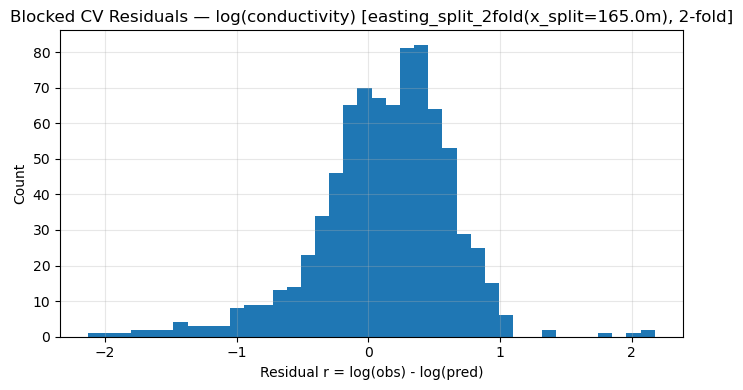

0.6609149905626683

In [19]:
# --- Section 6.1: Empirical Calibration of Prediction Uncertainty (Spatial CV) ---
# Strategy: directional blocking with easting bands sized to the variogram practical range.
# Rationale: site is compact relative to range; we avoid leaky random K-fold and accept 2-fold if needed.

# 0) Inputs (use notebook objects)

df_cv = df_k[["easting", "northing", "conduc"]].dropna().copy()
X = df_cv[["easting", "northing"]].to_numpy(dtype=float)
z = np.log(df_cv["conduc"].to_numpy(dtype=float))  # log-conductivity scale

# Variogram practical range from fitted spherical params (log conductivity)
nugget_log, sill_plateau_log, range_log = params_conduc_log_sph
practical_range_log = float(range_log)


# 1) Survey geometry

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
x_span = x_max - x_min
y_span = y_max - y_min

print("Survey geometry:")
print(f"  X span: {x_span:.1f} m   (min={x_min:.1f}, max={x_max:.1f})")
print(f"  Y span: {y_span:.1f} m   (min={y_min:.1f}, max={y_max:.1f})")
print(f"  Variogram practical range (log conduc): {practical_range_log:.1f} m")
print(f"  Span / range ratios: X={x_span/practical_range_log:.2f}, Y={y_span/practical_range_log:.2f}")


# 2) Create easting-band groups (directional blocking)
# Use exactly two balanced bands (left/right halves). This avoids a degenerate "tiny third band"
# when x_span is only ~2x the practical range.

x_split = x_min + 0.5 * x_span
groups = (X[:, 0] >= x_split).astype(int)   # 0 = left half, 1 = right half
n_groups = 2
method = f"easting_split_2fold(x_split={x_split:.1f}m)"

print("\nCV method selection:")
print(f"  method = {method}")
print(f"  groups available = {n_groups}")

# Optional sanity check: report fold sizes
n0 = int((groups == 0).sum())
n1 = int((groups == 1).sum())
print(f"  points per group: left={n0}, right={n1}")

# 3) CV folds: fixed at 2-fold by construction
n_splits = 2

print("\nCV folds:")
print(f"  n_splits = {n_splits} (fixed)")

gkf = GroupKFold(n_splits=n_splits)

# 4) CV loop: krige on training, predict test points, compute residuals + leakage diagnostics

residuals = []
fold_rows = []
leakage_rows = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, z, groups=groups), start=1):
    X_train, z_train = X[train_idx], z[train_idx]
    X_test,  z_test  = X[test_idx],  z[test_idx]

    ok = OrdinaryKriging(
        X_train[:, 0], X_train[:, 1], z_train,
        variogram_model="spherical",
        variogram_parameters=vk_conduc_log,
        enable_plotting=False,
        verbose=False
    )

    z_pred, _ = ok.execute("points", X_test[:, 0], X_test[:, 1])
    z_pred = np.asarray(z_pred, dtype=float).ravel()

    r = z_test - z_pred
    residuals.append(r)

    rmse = float(np.sqrt(mean_squared_error(z_test, z_pred)))
    med_abs = float(np.median(np.abs(r)))
    fold_rows.append({"fold": fold, "n_test": len(test_idx), "rmse_log": rmse, "median_abs_log": med_abs})

    # Leakage diagnostic: distance from each test point to nearest training point
    dmin = cdist(X_test, X_train).min(axis=1)
    pct_within_range = float((dmin < practical_range_log).mean() * 100.0)
    leakage_rows.append({
        "fold": fold,
        "pct_test_within_1_range": pct_within_range,
        "median_min_dist": float(np.median(dmin))
    })

    print(
        f"Fold {fold:>2d}: n_test={len(test_idx):>3d} | RMSE(log)={rmse:.4f} | median|r|={med_abs:.4f} "
        f"| leakage={pct_within_range:.1f}% (med dmin={np.median(dmin):.1f} m)"
    )

residuals = np.concatenate(residuals)


# 5) Global sigma_cv_log (conservative)

rmse_log = float(np.sqrt(np.mean(residuals**2)))
mad = float(np.median(np.abs(residuals - np.median(residuals))))
sigma_mad = 1.4826 * mad
sigma_cv_log = max(rmse_log, sigma_mad)

# Conservative inflation if folds are limited (esp. 2-fold)
if n_splits == 2:
    safety_factor = 1.25
    sigma_cv_log *= safety_factor
    print(f"\nApplied safety inflation factor {safety_factor:.2f}x due to limited folds (n_splits=2).")

print("\nCV residual summary (log conductivity):")
print(f"  RMSE(log)            = {rmse_log:.4f}")
print(f"  Robust sigma (MAD)   = {sigma_mad:.4f}")
print(f"  Chosen sigma_cv_log  = {sigma_cv_log:.4f}")

# Optional intuition on original scale (multiplicative error)
mult = np.exp(residuals)
print(f"  Median exp(residual)   = {np.median(mult):.3f}")
print(f"  90th pct exp(residual) = {np.percentile(mult, 90):.3f}")


# 6) Quick diagnostics plot

plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=40)
plt.title(f"Blocked CV Residuals — log(conductivity) [{method}, {n_splits}-fold]")
plt.xlabel("Residual r = log(obs) - log(pred)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Make sigma_cv_log available for Section 6.3
sigma_cv_log


#### Blocked CV Geometry and Limitations

The survey spans approximately two correlation lengths along its longest axis and approximately 1.5 correlation lengths across profiles (practical range ≈ 161.5 m). This limits the number of spatially independent validation folds that can be constructed without introducing train–test leakage.

To avoid optimistic error estimates, a conservative two-fold blocked cross-validation scheme is used, splitting the site into left and right halves along the easting direction. Smaller blocks or random K-fold cross-validation would artificially inflate apparent model performance by allowing strong spatial dependence between training and test data.

Even under this conservative blocking, most test locations remain within one correlation range of training data, reflecting the compact site geometry. As a result, the cross-validation residuals are interpreted as conservative lower bounds on prediction error, and the resulting uncertainty estimates are inflated modestly to account for limited fold independence.

### 6.2 Threshold Selection and Sensitivity Analysis

Probability-of-exceedance calculations require the specification of one or more thresholds representing values of practical interest. In environmental and exploration contexts, such thresholds are rarely absolute; instead, they reflect trade-offs between coverage, confidence, and the cost of follow-up investigation. Accordingly, threshold selection is treated here as a modeling assumption to be evaluated, not a fixed truth.

For this analysis, thresholds are defined using empirical distributional properties of the observed data rather than external regulatory criteria. This approach is appropriate given the instructional nature of the dataset, the absence of ground-truth characterization data, and the goal of illustrating uncertainty-aware decision support. Thresholds are evaluated through probability-of-exceedance calculations rather than binary exceedance of interpolated values, allowing uncertainty to be incorporated explicitly.

Specifically, exceedance probabilities are evaluated for multiple candidate thresholds, including:

- The 90th percentile, representing a moderate anomaly threshold that balances sensitivity and spatial continuity.

- The 95th percentile, representing a more conservative threshold emphasizing high-confidence, spatially compact anomalies.

- A robust background-based threshold (median plus two times the interquartile range), intended to reduce sensitivity to extreme outliers.

Sensitivity to threshold choice is assessed by examining how the spatial extent, coherence, and number of exceedance regions change across these definitions. In practice, higher thresholds reduce the spatial footprint of exceedance areas and tend to fragment anomalies into isolated features, while lower thresholds increase coverage but include regions with weaker contrast and lower confidence.

For subsequent probability-of-exceedance mapping, the 90th percentile threshold is used as a primary reference case. This choice reflects a balance between anomaly coherence and spatial extent, capturing features supported by multiple observations without excessive fragmentation. Results for alternative thresholds are retained for comparison and interpretation.

This explicit treatment of threshold sensitivity emphasizes that exceedance probabilities are conditional on modeling choices and should be interpreted comparatively rather than as absolute statements.

In [20]:
# --- Section 6.2: Threshold selection (distribution-based) ---

# Use the cleaned conductivity observations (same source used for variograms/kriging)
conduc_obs = df_k["conduc"].dropna().to_numpy(dtype=float)

# Candidate thresholds on the original scale (mS/m)
T90 = float(np.percentile(conduc_obs, 90))
T95 = float(np.percentile(conduc_obs, 95))

q1 = float(np.percentile(conduc_obs, 25))
q3 = float(np.percentile(conduc_obs, 75))
iqr = q3 - q1
median = float(np.median(conduc_obs))

T_bg = median + 2.0 * iqr  # robust background-based threshold (as defined in text)

# Thresholds on log scale (used for probability-of-exceedance in Section 6.3)
t90 = float(np.log(T90))
t95 = float(np.log(T95))
t_bg = float(np.log(T_bg))

thresholds = pd.DataFrame(
    {
        "threshold": ["p90", "p95", "median + 2*IQR"],
        "T_mS_per_m": [T90, T95, T_bg],
        "log(T)": [t90, t95, t_bg],
    }
)

print("Candidate thresholds (from observed conductivity):")
display(thresholds)

# Quick sanity check (helps interpretation for heavy-tailed data)
print("\nSanity check:")
print(f"  median = {median:.2f} | Q1 = {q1:.2f} | Q3 = {q3:.2f} | IQR = {iqr:.2f}")
print(f"  ordering: T90={T90:.2f} | T95={T95:.2f} | T_bg={T_bg:.2f}")


Candidate thresholds (from observed conductivity):


,threshold,T_mS_per_m,log(T)
0,p90,31.90,3.462606
1,p95,34.60,3.543854
2,median + 2*IQR,47.05,3.851211



Sanity check:
  median = 19.70 | Q1 = 13.93 | Q3 = 27.60 | IQR = 13.68
  ordering: T90=31.90 | T95=34.60 | T_bg=47.05


Notably, the robust background threshold lies above the 95th percentile, indicating a heavy-tailed distribution and providing a deliberately conservative reference case.

## 6.3 Probability-of-Exceedance Computation

This section computes probability-of-exceedance (PoE) maps for apparent conductivity on the original mS/m scale using the kriged log-conductivity mean and a calibrated uncertainty model. Exceedance probabilities are interpreted as decision-support rankings, not as fully calibrated posterior probabilities.

### Approach

Candidate thresholds T are defined from the empirical distribution of observed conductivity (Section 6.2), including:

- 90th percentile

- 95th percentile

- robust background threshold (median + 2×IQR)

All computations are performed on the log-conductivity scale, consistent with the kriging model and variogram analysis.

At each spatial location s, we treat log-conductivity as approximately normal and compute:

#### Probability of exceedance

PoE(s; T) = P(C(s) > T) = 1 - Φ( (log(T) - μ_log(s)) / σ_cal(s) )

where:

μ_log(s) = kriged mean of log-conductivity

σ_cal(s) = calibrated prediction standard deviation

Φ(.) = standard normal cumulative distribution function

#### Calibrated uncertainty model

Calibrated uncertainty combines geometric interpolation uncertainty with an empirical error term derived from blocked spatial cross-validation (Section 6.1):

σ_cal(s) = sqrt( σ_krig(s)^2 + σ_CV^2 )

where:

σ_krig(s) = kriging standard deviation

σ_CV = global empirical error estimate from blocked CV residuals (inflated modestly to reflect limited fold independence)

This conservative formulation prevents exceedance probabilities from being overstated in regions where kriging variance is small but empirical model error remains significant.

#### Interpretation

PoE maps are interpreted comparatively across thresholds and probability levels. Higher PoE values identify locations where elevated conductivity is both predicted and supported by the calibrated uncertainty model. Because the survey domain is compact relative to the inferred correlation length, PoE values should be understood as relative rankings under stated modeling assumptions, not as absolute probabilities of contamination or material presence.

In code terms (for reference):

z = (logT - mu_log_grid) / sigma_cal_grid

PoE = 1 - norm.cdf(z)

Calibrated uncertainty summary (log conductivity):
  sigma_cv_log (global) = 0.6609

Grid sigma_krig_log summary:
  min     = 0.000000e+00
  p10     = 0.000000e+00
  median  = 0.000000e+00
  p90     = 1.193727e-07
  max     = 2.437522e-01

Grid sigma_cal_log summary:
  min     = 0.6609
  median  = 0.6609
  max     = 0.7044

Relative contribution of kriging uncertainty:
  median(sigma_krig / sigma_cal) = 0.000
  max(sigma_krig / sigma_cal)    = 0.346


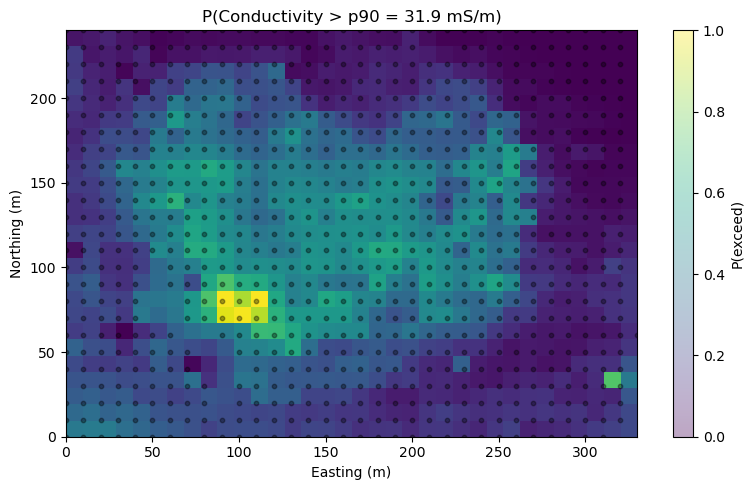

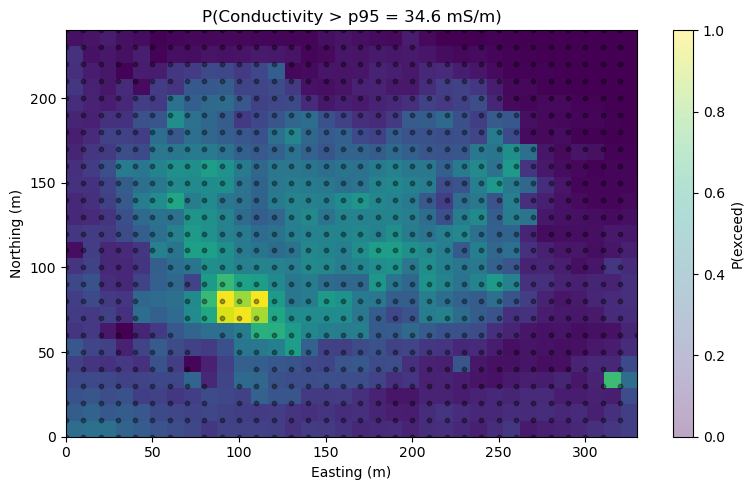

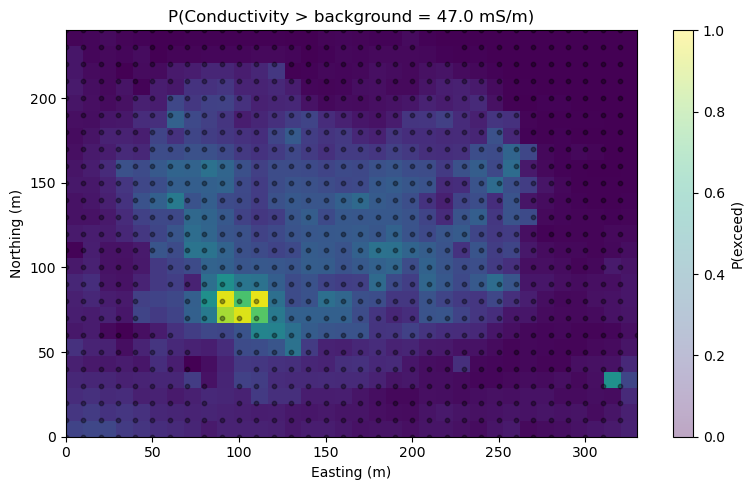


Fraction of grid cells above probability cutoffs:
  p90: P>=0.30:  0.386 | P>=0.50:  0.096 | P>=0.80:  0.007
  p95: P>=0.30:  0.324 | P>=0.50:  0.048 | P>=0.80:  0.007
   bg: P>=0.30:  0.075 | P>=0.50:  0.008 | P>=0.80:  0.005


In [22]:
# --- Section 6.3: Probability-of-Exceedance (PoE) Maps ---

# Assumes from earlier sections:
#   z_conduc_log_hat : kriged mean of log(conductivity) on the grid
#   var_conduc_log   : kriging variance of log(conductivity) on the grid
#   gridx, gridy     : grid coordinate arrays
#   df_k             : cleaned observations (easting, northing, conduc)
#   T90, T95, T_bg   : thresholds on original scale (mS/m)
#   t90, t95, t_bg   : thresholds on log scale
#   sigma_cv_log     : calibrated global CV error (log scale), inflated if n_splits=2

# 1) Calibrated uncertainty model (log scale)

mu_log = z_conduc_log_hat

# Numerical safety
var_conduc_log = np.clip(var_conduc_log, 0.0, None)

sigma_krig_log = np.sqrt(var_conduc_log)
sigma_cal_log  = np.sqrt(sigma_krig_log**2 + sigma_cv_log**2)

print("Calibrated uncertainty summary (log conductivity):")
print(f"  sigma_cv_log (global) = {sigma_cv_log:.4f}")

print("\nGrid sigma_krig_log summary:")
print(f"  min     = {np.nanmin(sigma_krig_log):.6e}")
print(f"  p10     = {np.nanpercentile(sigma_krig_log, 10):.6e}")
print(f"  median  = {np.nanmedian(sigma_krig_log):.6e}")
print(f"  p90     = {np.nanpercentile(sigma_krig_log, 90):.6e}")
print(f"  max     = {np.nanmax(sigma_krig_log):.6e}")

print("\nGrid sigma_cal_log summary:")
print(f"  min     = {np.nanmin(sigma_cal_log):.4f}")
print(f"  median  = {np.nanmedian(sigma_cal_log):.4f}")
print(f"  max     = {np.nanmax(sigma_cal_log):.4f}")

# Relative contribution of geometric vs empirical uncertainty
ratio = sigma_krig_log / sigma_cal_log
print("\nRelative contribution of kriging uncertainty:")
print(f"  median(sigma_krig / sigma_cal) = {np.nanmedian(ratio):.3f}")
print(f"  max(sigma_krig / sigma_cal)    = {np.nanmax(ratio):.3f}")


# 2) Probability-of-exceedance on the grid
# PoE(s; T) = 1 - Phi( (log(T) - mu_log(s)) / sigma_cal_log(s) )

thresholds_log = {
    "p90": t90,
    "p95": t95,
    "bg":  t_bg,   # median + 2*IQR
}

thresholds_mS = {
    "p90": T90,
    "p95": T95,
    "bg":  T_bg,
}

eps = 1e-12  # protect against division by zero

P_exceed = {}
for name, logT in thresholds_log.items():
    zscore = (logT - mu_log) / np.maximum(sigma_cal_log, eps)
    P_exceed[name] = 1.0 - norm.cdf(zscore)


# 3) Plotting helper

def plot_prob_map(gridx, gridy, P, title):
    plt.figure(figsize=(8, 5))
    plt.imshow(
        P,
        origin="lower",
        extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()],
        vmin=0.0, vmax=1.0,
        aspect="auto"
    )
    plt.scatter(df_k["easting"], df_k["northing"], s=10, c="k", alpha=0.35)
    plt.title(title)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    cbar = plt.colorbar()
    cbar.set_label("P(exceed)")
    plt.tight_layout()
    plt.show()


# 4) Probability-of-exceedance maps

plot_prob_map(
    gridx, gridy, P_exceed["p90"],
    f"P(Conductivity > p90 = {thresholds_mS['p90']:.1f} mS/m)"
)

plot_prob_map(
    gridx, gridy, P_exceed["p95"],
    f"P(Conductivity > p95 = {thresholds_mS['p95']:.1f} mS/m)"
)

plot_prob_map(
    gridx, gridy, P_exceed["bg"],
    f"P(Conductivity > background = {thresholds_mS['bg']:.1f} mS/m)"
)


# 5) Simple sensitivity summary

def frac_cells_above(P, p_cut):
    valid = np.isfinite(P)
    if valid.sum() == 0:
        return np.nan
    return float((P[valid] >= p_cut).mean())

print("\nFraction of grid cells above probability cutoffs:")
for name in ["p90", "p95", "bg"]:
    P = P_exceed[name]
    f30 = frac_cells_above(P, 0.30)
    f50 = frac_cells_above(P, 0.50)
    f80 = frac_cells_above(P, 0.80)
    print(
        f"  {name:>3s}: "
        f"P>=0.30: {f30:6.3f} | "
        f"P>=0.50: {f50:6.3f} | "
        f"P>=0.80: {f80:6.3f}"
    )


#### Summary and Interpretation

Probability-of-exceedance (PoE) maps exhibit a consistent and interpretable pattern across all tested thresholds. A single dominant anomaly is present in the central portion of the site, with elevated PoE values persisting across the 90th percentile, 95th percentile, and robust background thresholds. As expected, increasing the threshold progressively reduces the spatial extent of exceedance while preserving the core of this anomaly, indicating that it is supported by multiple observations rather than being an artifact of interpolation.

Calibrated uncertainty is dominated by the empirical cross-validation term, with the kriging standard deviation contributing only a minor fraction of the total uncertainty across most of the grid. As a result, PoE values are intentionally conservative: moderate contrasts are downweighted, and only the strongest anomalies achieve high exceedance probabilities. This behavior is consistent with the compact survey geometry relative to the inferred correlation length and reflects a deliberate choice to avoid overstating confidence.

Sensitivity analysis confirms that exceedance regions shrink rapidly as probability cutoffs increase. At the 90th percentile threshold, approximately 10% of the grid exceeds a PoE of 0.5, while less than 1% of the grid exceeds this level for the robust background threshold. Regions with PoE greater than 0.8 are limited to a very small area near the central anomaly across all thresholds, highlighting locations where elevated conductivity is both predicted and supported under conservative uncertainty assumptions.

Overall, these results demonstrate how probability-of-exceedance mapping can be used to rank spatial features by relative confidence rather than to make binary exceedance claims. The PoE maps provide a transparent, uncertainty-aware basis for prioritizing follow-up investigation while explicitly acknowledging the limitations imposed by survey extent, spatial correlation, and model assumptions.

### 6.4 Cross-Channel Comparison: Conductivity vs In-Phase

The in-phase component of the EM31 response provides complementary information to apparent conductivity but reflects different physical sensitivities. While conductivity primarily responds to bulk subsurface electrical properties, the in-phase signal is more sensitive to near-surface metallic objects, highly conductive inclusions, and coupling effects. As such, the in-phase channel is treated here as an interpretive corroboration layer rather than a primary target for probability-of-exceedance analysis.

Spatial comparison of the kriged conductivity and in-phase surfaces reveals partial co-location between the dominant conductivity anomaly identified in Section 6.3 and elevated in-phase response. This spatial overlap strengthens confidence that the conductivity anomaly represents a physically meaningful feature rather than an interpolation artifact. The coincidence of elevated responses in both channels is consistent with heterogeneous conductive material within the landfill footprint, potentially including metallic debris or highly conductive waste components.

Outside of this central region, in-phase anomalies are more spatially scattered and frequently lack corresponding conductivity support. These isolated in-phase highs are interpreted cautiously, as they may reflect localized surface or near-surface effects rather than laterally extensive conductive zones. Their absence of conductivity corroboration suggests limited relevance for broader subsurface characterization or follow-up prioritization.

Importantly, no probability-of-exceedance maps are computed for the in-phase channel. The in-phase data exhibit greater spike-dominated behavior, weaker variogram structure, and higher sensitivity to small-scale heterogeneity. Treating in-phase symmetrically with conductivity in a probabilistic framework would risk overstating confidence and obscuring its diagnostic role. Instead, in-phase response is used qualitatively to support, refine, or temper interpretations derived from the conductivity-based exceedance analysis.

In this framework, regions where elevated conductivity probability coincides with elevated in-phase response are interpreted as higher-confidence targets for follow-up investigation, while regions showing divergence between channels warrant caution. This cross-channel comparison reinforces the decision-support emphasis of the analysis: prioritizing spatial features based on relative confidence and consistency across independent measurements, rather than relying on any single metric in isolation.

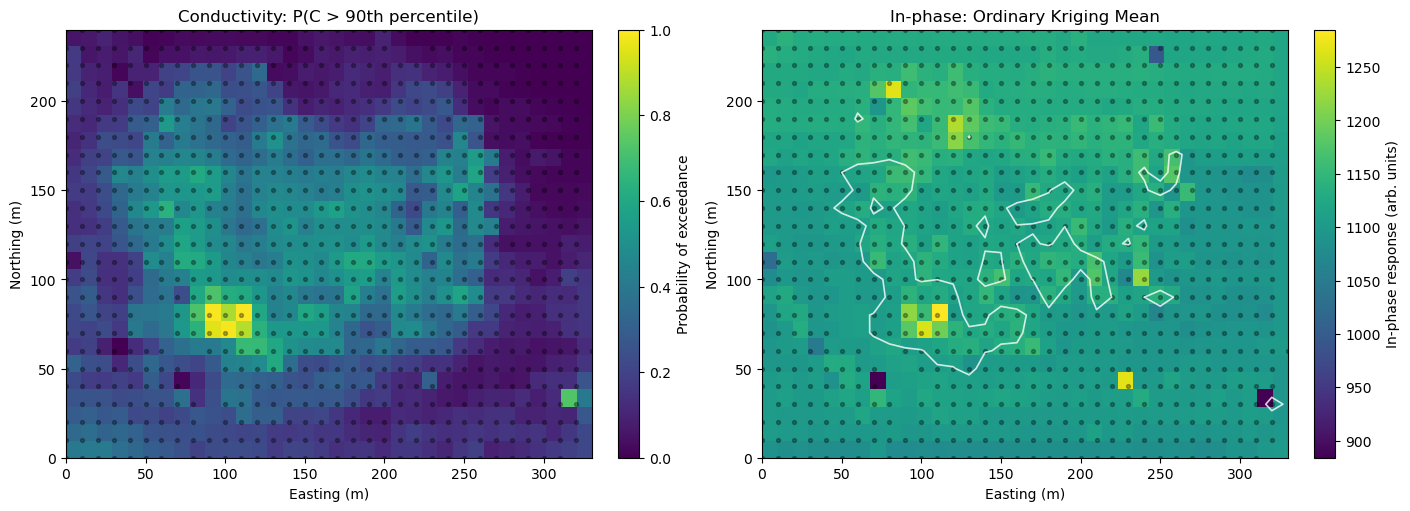

In [24]:
# ----------------------------------------
# Cross-channel comparison figure
# Conductivity PoE vs In-phase response
# ----------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# ---- Panel A: Conductivity probability-of-exceedance (primary threshold)
im0 = axes[0].imshow(
    P_exceed["p90"],
    origin="lower",
    extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()],
    vmin=0.0, vmax=1.0,
    aspect="auto"
)
axes[0].scatter(df_k["easting"], df_k["northing"], s=8, c="k", alpha=0.3)
axes[0].set_title("Conductivity: P(C > 90th percentile)")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Probability of exceedance")

# ---- Panel B: In-phase kriged mean
im1 = axes[1].imshow(
    z_inphase_hat,
    origin="lower",
    extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()],
    aspect="auto"
)
axes[1].scatter(df_k["easting"], df_k["northing"], s=8, c="k", alpha=0.3)
axes[1].set_title("In-phase: Ordinary Kriging Mean")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("In-phase response (arb. units)")

axes[1].contour(
    P_exceed["p90"],
    levels=[0.5],
    colors="white",
    linewidths=1.2,
    alpha=0.8,
    extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()]
)

plt.show()


Side-by-side comparison of conductivity probability-of-exceedance (90th percentile threshold; left) and kriged in-phase response (right); the white contour on the in-phase map delineates the P = 0.5 conductivity exceedance boundary, highlighting areas of cross-channel agreement and supporting interpretation of higher-confidence anomalies.

## 7. Conclusions

This analysis demonstrates an uncertainty-aware geostatistical workflow applied to legacy, student-collected EM31 data under realistic constraints. Rather than optimizing for visual smoothness or apparent precision, the workflow emphasizes principled handling of spatial correlation, explicit separation of interpolation geometry from predictive uncertainty, and conservative framing of results for decision support.

Apparent conductivity data exhibit strong spatial structure after log transformation, with variogram analysis indicating a practical correlation range of approximately 160 m. Ordinary kriging captures the dominant spatial patterns, including a central anomaly consistent with the known landfill footprint. Kriging variance highlights areas of sparse sampling and edge effects but is correctly treated as a geometric diagnostic rather than a measure of predictive confidence.

To obtain defensible uncertainty estimates, kriging variance is calibrated using spatially blocked cross-validation. The compact site geometry—spanning only ~2 correlation lengths along its longest axis—limits the number of spatially independent validation folds. Rather than introducing spatial leakage through smaller blocks or random K-fold validation, a conservative two-fold split along the easting direction is used and explicitly documented. Empirical residuals from this procedure dominate the calibrated uncertainty, ensuring that probability-of-exceedance estimates err on the side of caution.

Probability-of-exceedance maps provide a transparent, uncertainty-aware ranking of spatial features relative to empirically defined thresholds. Across all tested thresholds, a single dominant anomaly persists with elevated exceedance probability, while weaker features are progressively downweighted as uncertainty is incorporated. Sensitivity analysis confirms that exceedance areas shrink rapidly with increasing thresholds and probability cutoffs, reinforcing the interpretation of PoE as a comparative decision-support tool rather than a binary classification.

The in-phase component is incorporated as a complementary interpretive layer rather than a primary exceedance variable. Partial spatial co-location between elevated in-phase response and high conductivity exceedance strengthens confidence in the central anomaly, while isolated in-phase highs lacking conductivity support are interpreted cautiously. This asymmetric treatment reflects the differing physical sensitivities of the two channels and avoids overstating confidence where uncertainty is poorly constrained.

Overall, this project illustrates how geostatistical modeling can be integrated with modern uncertainty calibration practices to produce outputs that are honest about their limitations and useful for prioritization and follow-up planning. The approach is intentionally conservative, transparent, and reproducible, making it well suited for instructional settings, portfolio demonstration, and early-stage site characterization where decision quality matters more than apparent precision.

## 8. Some Things That Could Be Done Next

Several natural extensions of this analysis could be pursued to further refine interpretation and reduce uncertainty, particularly if additional data or field access were available. These are presented as illustrative possibilities rather than a fixed roadmap.

One straightforward extension would be targeted infill sampling in areas where probability-of-exceedance is elevated but uncertainty remains high, especially along the margins of the central conductivity anomaly. Infill measurements oriented perpendicular to existing survey lines would help resolve spatial gradients, strengthen variogram estimation, and increase the number of spatially independent validation folds.

With an expanded dataset, directional variogram analysis could be revisited to evaluate potential anisotropy associated with survey orientation or landfill geometry. Incorporating anisotropy into the kriging model may improve interpolation performance and uncertainty representation without substantially increasing model complexity.

Additional interpretation of the in-phase component could also be supported through focused follow-up at selected locations, either via targeted ground truthing or complementary geophysical methods such as magnetics or shallow GPR. This would help distinguish responses associated with metallic debris from those reflecting broader conductive material.

Finally, if the spatial extent or density of the survey were increased, uncertainty calibration could be repeated using multi-fold spatial cross-validation. This would allow empirical prediction error to be estimated more robustly and potentially localized, improving the interpretability of probability-of-exceedance maps and enabling clearer assessment of survey design trade-offs.

These extensions highlight how uncertainty-aware geostatistical modeling can guide iterative data collection and interpretation, rather than serving as a static endpoint.